In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.stats import norm
from tensorflow import keras
from tensorflow.keras import layers, utils
from tensorflow.keras.datasets import mnist

from tensorflow.keras import backend as K

In [52]:
IMG_SIZE = 64
BATCH_SIZE = 128
CHANNELS = 3
LATENT_DIM = 200
EPOCHS = 10
BETA = 2000
DROPDOWN_RATE = 0.3
LEARN_RATE_INIT = 0.0005

In [45]:
def plot_sample(imgs, n=10):
    sample_ids = np.random.randint(0, len(imgs), size=n)
    sampled_imgs = imgs[sample_ids]

    fig, axes = plt.subplots(nrows=2, ncols=n // 2, figsize=(21, 9), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(sampled_imgs[i])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

def sample_batch(dataset):
    return dataset.take(1).get_single_element().numpy()


In [46]:
train_data = utils.image_dataset_from_directory(
    "faces_dat/archive/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train = train_data.map(lambda x: preprocess(x))

Found 202599 files belonging to 1 classes.


In [47]:
train_sample = sample_batch(train)

print(train_sample.shape)

(128, 64, 64, 3)


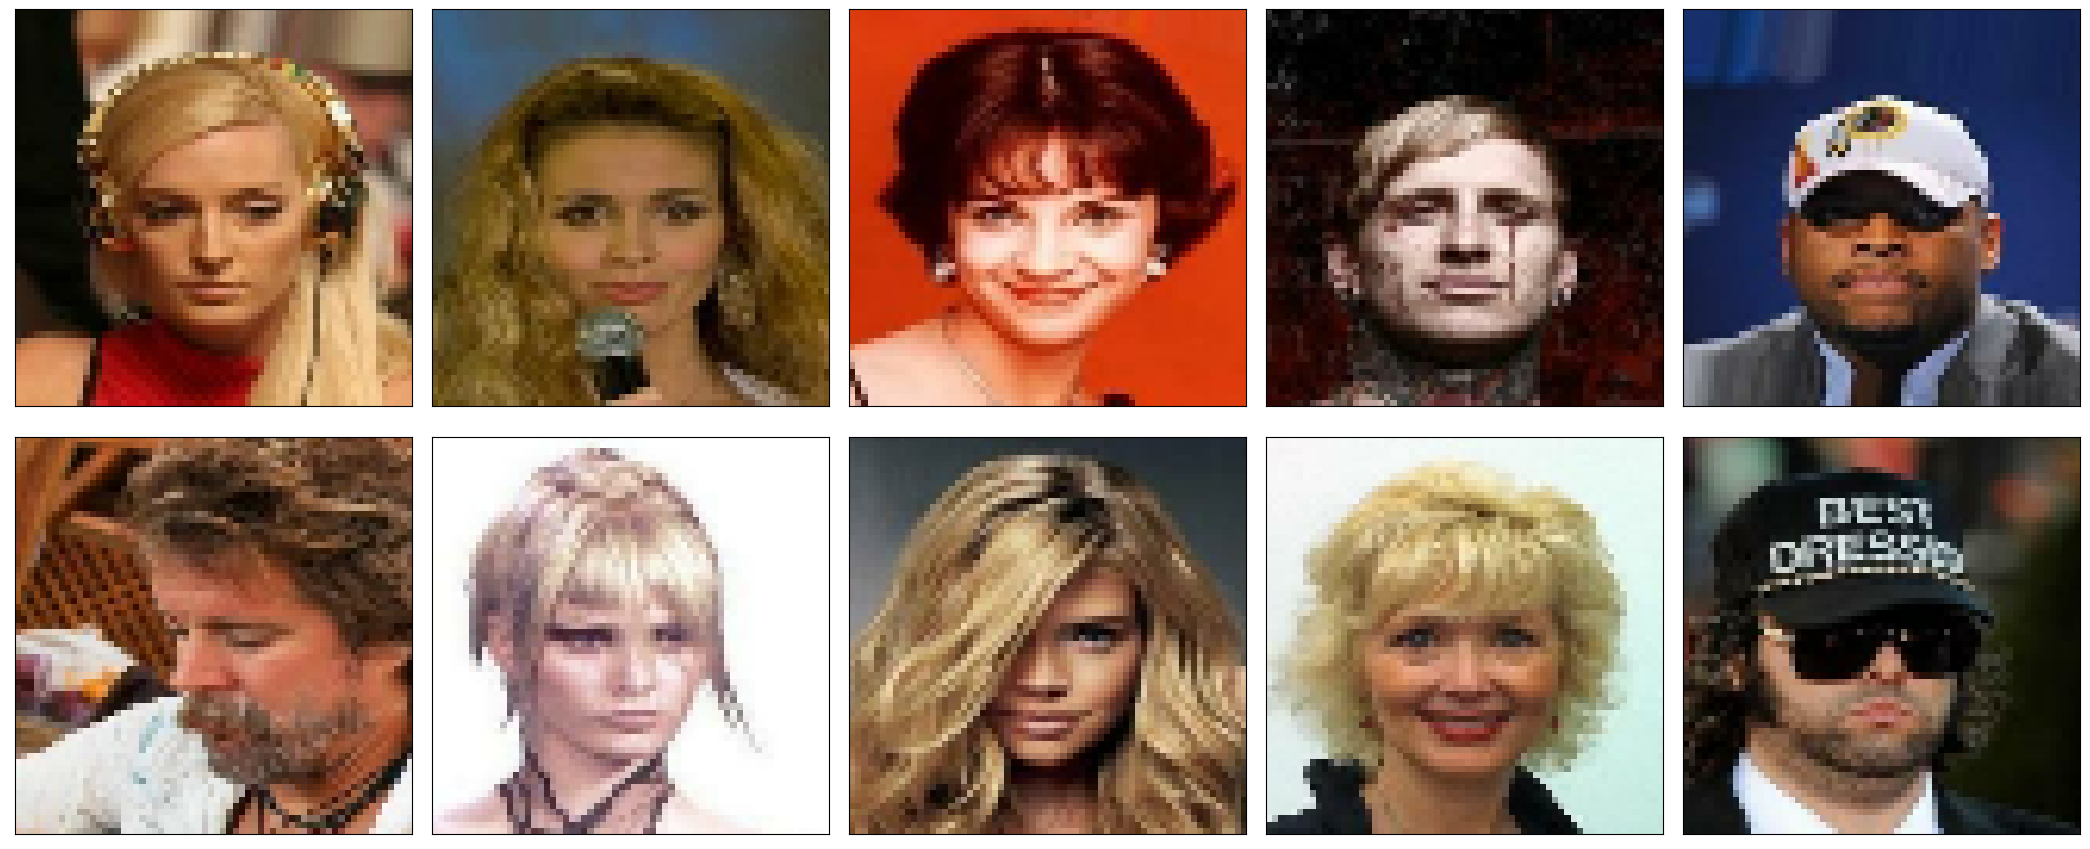

In [48]:
plot_sample(train_sample)

In [53]:
def apply_bn_and_dropout(x):
    return layers.Dropout(DROPDOWN_RATE)(layers.BatchNormalization()(x))

def make_encoder(input_dim: list, latent_dim: int):
    """Create encoder model.
    Args:
        input_dim : (list) dimensionality of the input, i.e. (height, width, channels)
        latent_dim: (int) dimesionality of the latent space
    Returns:
        keras Model
    """
    encoder_inputs = keras.Input(shape=input_dim, name="encoder_input")
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = apply_bn_and_dropout(x)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
    x = apply_bn_and_dropout(x)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    return encoder

def make_decoder(latent_dim: int):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(8 * 8 * 32, activation="relu")(latent_inputs)
    x = apply_bn_and_dropout(x)
    x = layers.Reshape((8, 8, 32))(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = apply_bn_and_dropout(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = apply_bn_and_dropout(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = apply_bn_and_dropout(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()
    return decoder

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                BETA * keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        


In [54]:
encoder = make_encoder((IMG_SIZE, IMG_SIZE, CHANNELS), LATENT_DIM)
decoder = make_decoder(LATENT_DIM)
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.legacy.Adam(LEARN_RATE_INIT))

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 32, 32, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization_56 (Ba  (None, 32, 32, 32)           128       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_56 (Dropout)        (None, 32, 32, 32)           0         ['batch_normalization_56

In [ ]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs_faces")


class ImageGenerator(keras.callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("output_faces/generated_img_%03d_%d.png" % (epoch, i))

In [55]:
vae.fit(
    train, 
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=LATENT_DIM),
    ]
)

Epoch 1/10
1583/1583 [==============================] - 152s 96ms/step - loss: 147.4747 - reconstruction_loss: 119.3872 - kl_loss: 4.9875
Epoch 2/10
1583/1583 [==============================] - 155s 98ms/step - loss: 100.7917 - reconstruction_loss: 91.1209 - kl_loss: 7.4665
Epoch 3/10
1529/1583 [===========================>..] - ETA: 5s - loss: 94.5258 - reconstruction_loss: 87.7560 - kl_loss: 6.2412

16/16 [==============================] - 0s 12ms/step
Example real faces


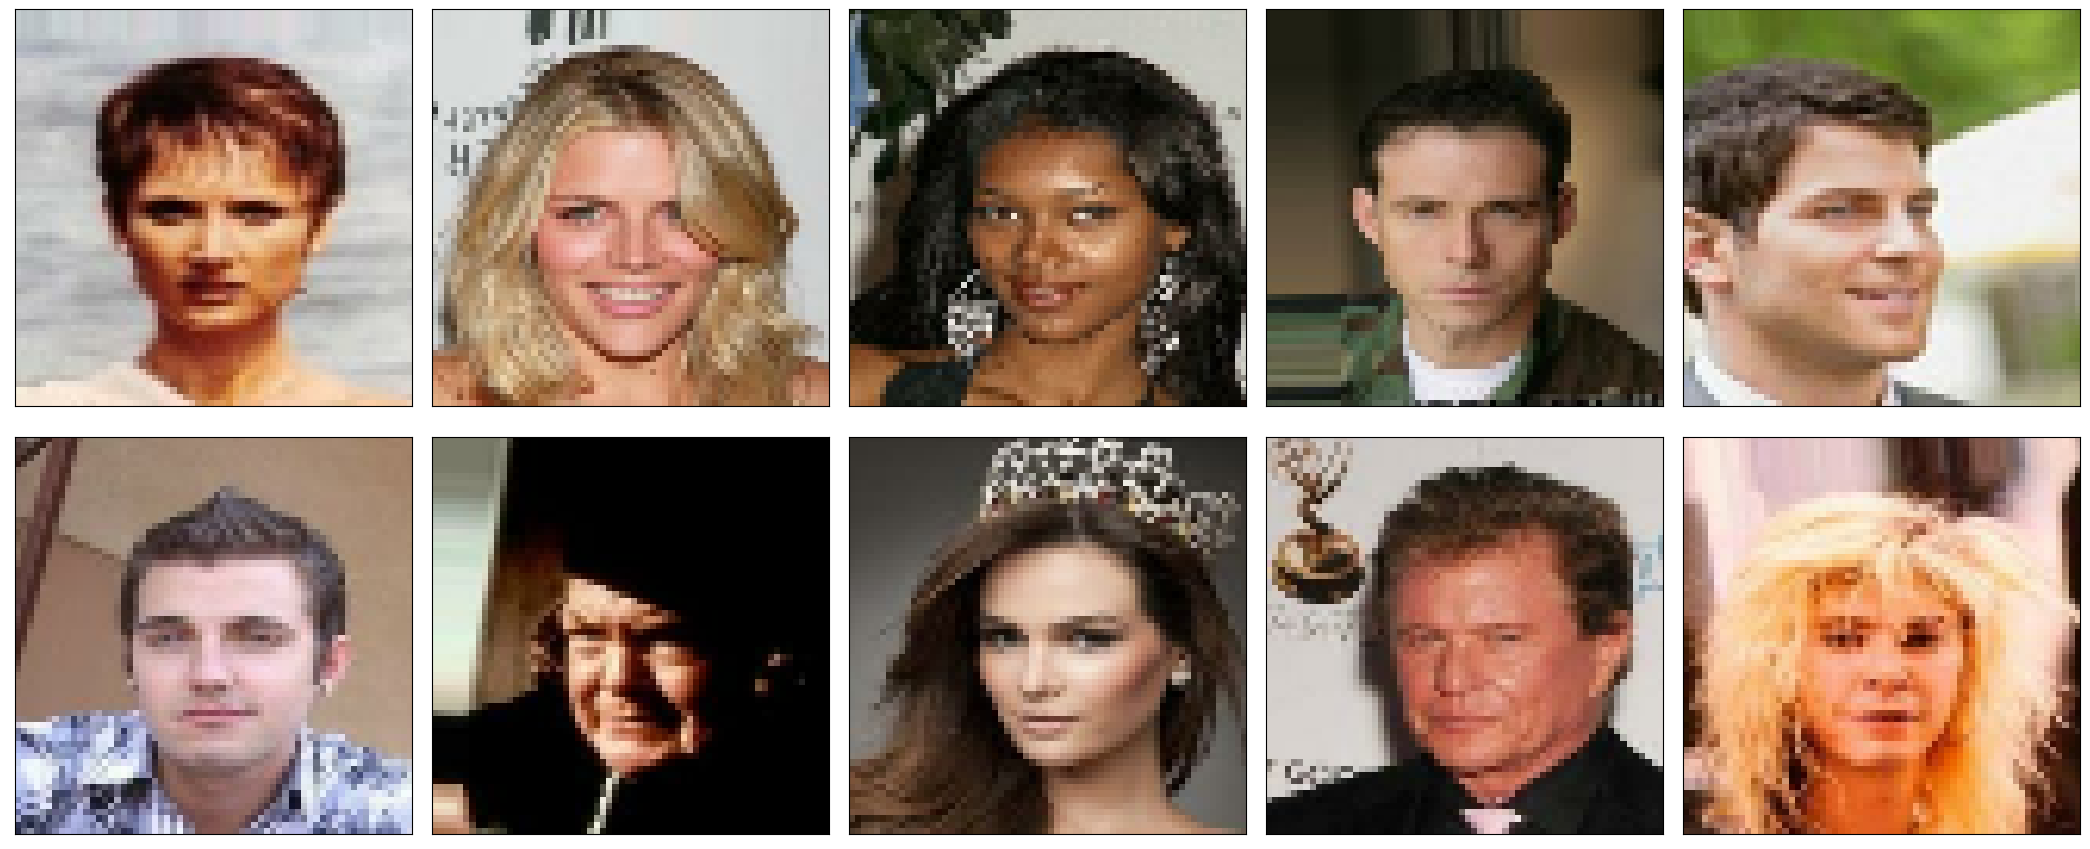

Reconstructions


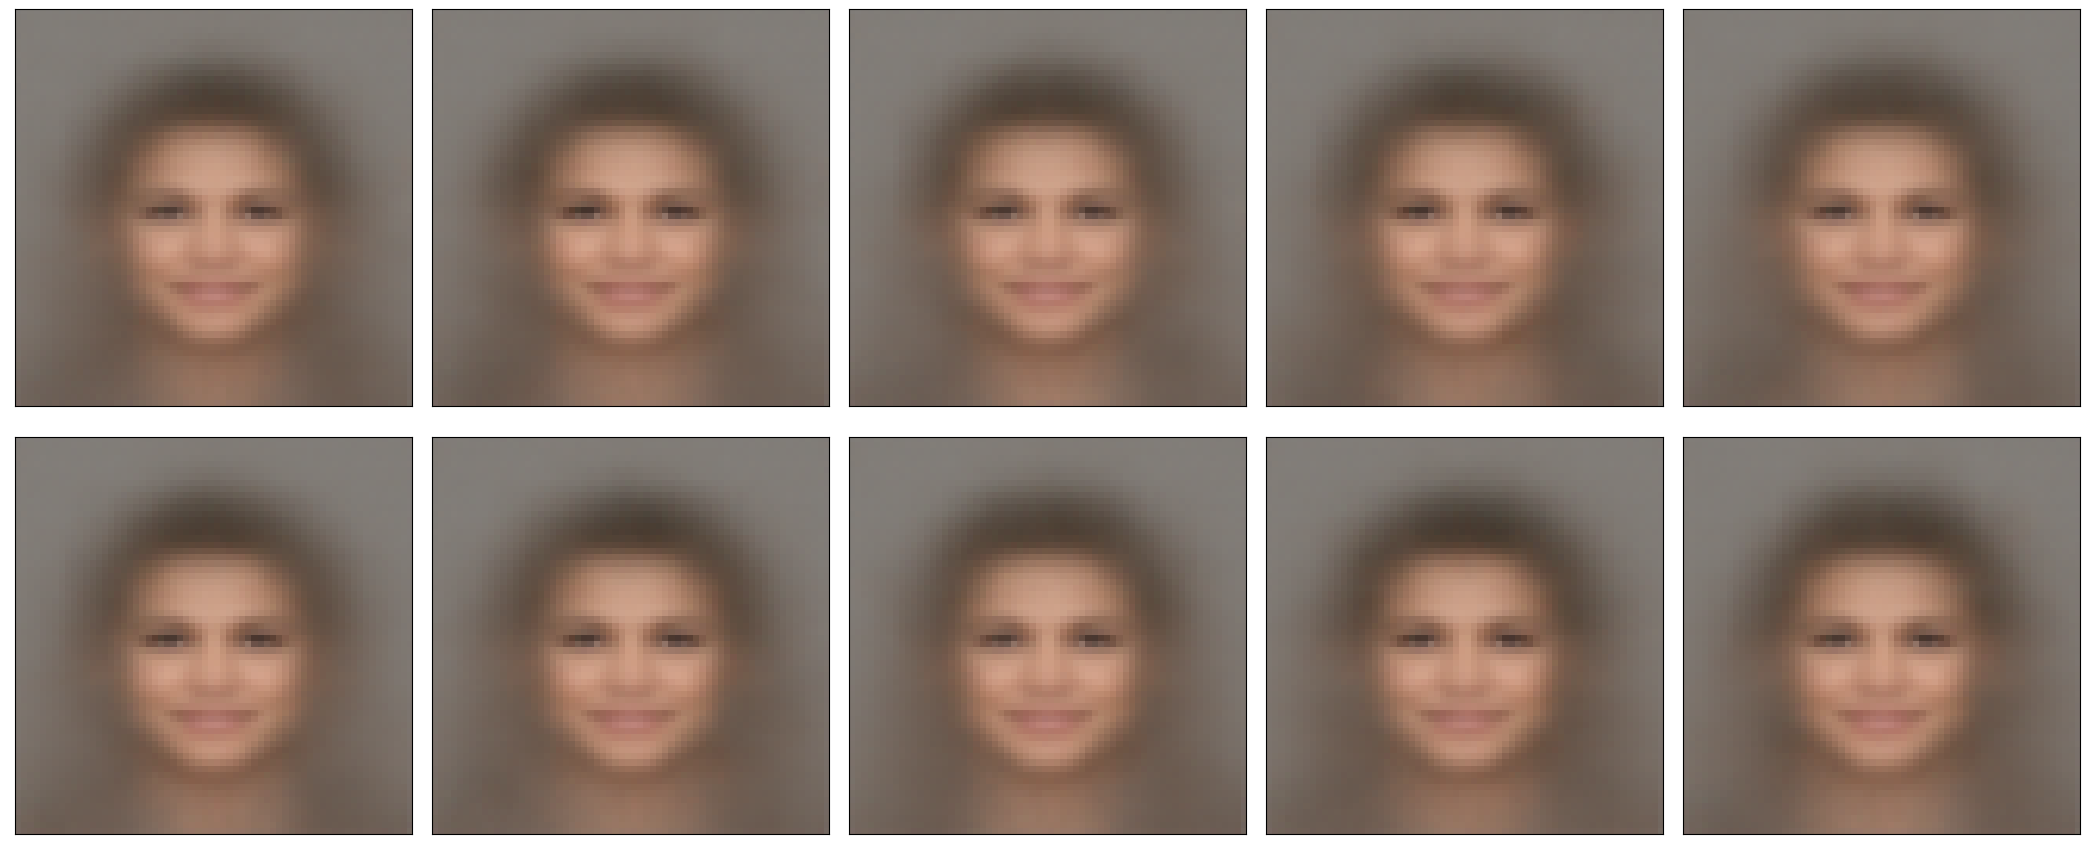

In [43]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

# Create autoencoder predictions and display
z_mean, z_log_var, z = vae.encoder.predict(example_images)
reconstructions = vae.decoder.predict(z)

print("Example real faces")
plot_sample(example_images)
print("Reconstructions")
plot_sample(reconstructions)



# Latent space distribution

In [ ]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()